In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import cv2
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt

In [20]:
# Load video using OpenCV
video_path = 'clouds.mp4'
cap = cv2.VideoCapture(video_path)

ret, frame = cap.read()
frame_width = 44
frame_height = 60

# Check if the video opened successfully
if not cap.isOpened():
    raise Exception("Error opening the video. Please check the file path and codec.")

# Define a torchvision transform for resizing
resize_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((frame_width, frame_height)),
    transforms.ToTensor(),
])

In [21]:
# Initialize a list to store video frames
frames = []

# Read frames from the video
while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Convert BGR image to RGB
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Apply resizing transform
    resized_frame = resize_transform(frame_rgb)

    # Append the frame to the list
    frames.append(resized_frame)

# Convert the list of frames to a PyTorch tensor
video_tensor = torch.stack(frames)

# Print tensor shape
print("Video Tensor Shape:", video_tensor.shape)

# Release the video capture object
cap.release()

Video Tensor Shape: torch.Size([329, 3, 44, 60])


In [195]:
class CloudDataset(Dataset):
    def __init__(self, image_sequence):
        self.ims = image_sequence
        self.ks = 5

    def __len__(self):
        return (self.ims.shape[0] - 1)

    def __getitem__(self, idx):
        return self.ims[idx], self.ims[idx + 1]
    
ds = CloudDataset(video_tensor)
data_loader = DataLoader(ds, batch_size=64, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


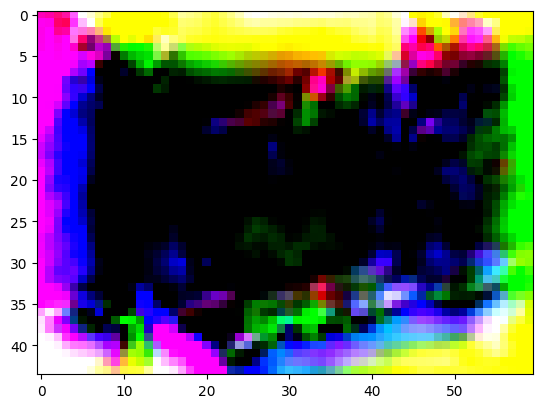

In [201]:
up2 = nn.Upsample(scale_factor=4, mode='bilinear', align_corners=True)

class Conv(nn.Module):
    def __init__(self, ks1=5, ks2=5):
        super().__init__()
        self.conv = nn.Conv2d(3, 3, kernel_size=ks1, padding=ks1//2, bias=False)
        self.conv2 = nn.Conv2d(3, 3, kernel_size=ks2, padding=ks2//2, bias=False)
        self.bn = nn.BatchNorm2d(3)

        # iniitalse kernels to have no effect
        # self.conv.weight.data.fill_(0)
        # self.conv2.weight.data.fill_(0)
        # self.conv2.weight.data[0, 0, 2, 2] = 1
        # self.conv2.weight.data[1, 1, 2, 2] = 1
        # self.conv2.weight.data[2, 2, 2, 2] = 1

    def forward(self, x):
        xdim = x.dim()
        if xdim == 3:
            x = x.unsqueeze(0)

        xd2 = transforms.Compose([transforms.Resize((frame_width // 4, frame_height // 4))])(x)
        xd2_up = up2(xd2)
        x2 = x - xd2_up
        xd2_n = self.conv2(xd2)
        x2_n = self.conv(x2)
        x_out = x2_n + up2(xd2_n)
        x_out = self.bn(x_out)

        if xdim == 3:
            x_out = x_out.squeeze(0)
        return x_out
    
model = Conv()

plt.imshow(model(ds[0][0]).permute(1, 2, 0).detach().numpy())

In [214]:
model = Conv(ks1=5, ks2=5)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0025, weight_decay=8e-4)

In [215]:
num_epochs = 250

for epoch in range(num_epochs):
    total_loss = 0.0

    for batch in data_loader:
        input_data = batch[0]
        targets = batch[1]
        
        optimizer.zero_grad()

        outputs = model(input_data)

        loss = criterion(outputs, targets)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    average_loss = total_loss / len(data_loader)
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {average_loss:.5f}')

Epoch 1/250, Loss: 1.19402
Epoch 2/250, Loss: 0.94294
Epoch 3/250, Loss: 0.86315
Epoch 4/250, Loss: 0.81286
Epoch 5/250, Loss: 0.76904
Epoch 6/250, Loss: 0.73156
Epoch 7/250, Loss: 0.69283
Epoch 8/250, Loss: 0.65927
Epoch 9/250, Loss: 0.62333
Epoch 10/250, Loss: 0.59389
Epoch 11/250, Loss: 0.56614
Epoch 12/250, Loss: 0.53399
Epoch 13/250, Loss: 0.50770
Epoch 14/250, Loss: 0.48209
Epoch 15/250, Loss: 0.45760
Epoch 16/250, Loss: 0.43492
Epoch 17/250, Loss: 0.41172
Epoch 18/250, Loss: 0.39072
Epoch 19/250, Loss: 0.36966
Epoch 20/250, Loss: 0.35057
Epoch 21/250, Loss: 0.33301
Epoch 22/250, Loss: 0.31383
Epoch 23/250, Loss: 0.29779
Epoch 24/250, Loss: 0.28174
Epoch 25/250, Loss: 0.26742
Epoch 26/250, Loss: 0.25300
Epoch 27/250, Loss: 0.23833
Epoch 28/250, Loss: 0.22654
Epoch 29/250, Loss: 0.21475
Epoch 30/250, Loss: 0.20128
Epoch 31/250, Loss: 0.19170
Epoch 32/250, Loss: 0.18046
Epoch 33/250, Loss: 0.16971
Epoch 34/250, Loss: 0.15997
Epoch 35/250, Loss: 0.15099
Epoch 36/250, Loss: 0.14284
E

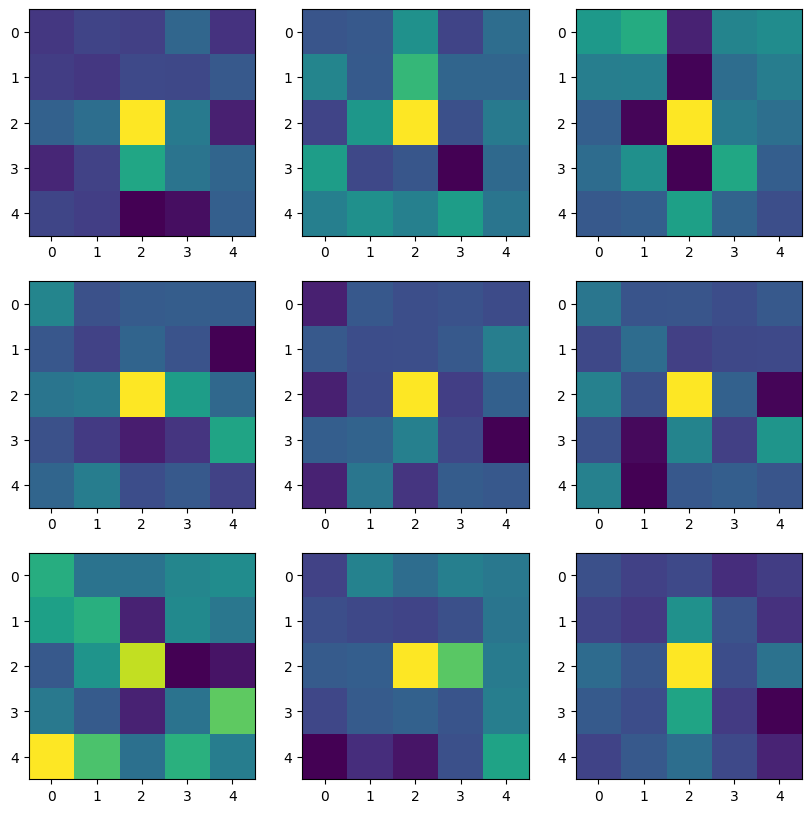

In [216]:
# plot heatmaps of all 9 kernels
fig, axs = plt.subplots(3, 3, figsize=(10, 10))
for i in range(3):
    for j in range(3):
        axs[i, j].imshow(model.conv2.weight[i, j].data.numpy())

/opt/homebrew/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB dat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


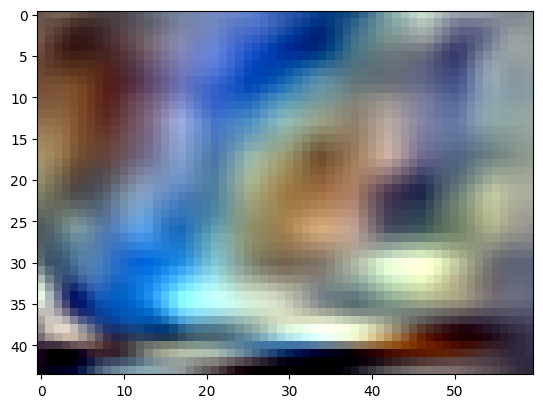

In [217]:
next_frame = ds[-1][0]

def update(frame):
    global next_frame
    # if frame < 50:
    #     plt.imshow(ds[-(50-frame+1)][0].permute(1, 2, 0))
    # else:
    next_frame = model(next_frame)
    plt.imshow(next_frame.detach().permute(1, 2, 0))

animation = FuncAnimation(plt.gcf(), update, frames=50, repeat=True, interval=50)

# save animarion as mp4 video file
# animation.save('hierarchy.mp4', writer='ffmpeg', fps=10, dpi=200)

from IPython.display import HTML
HTML(animation.to_jshtml())